<a href="https://colab.research.google.com/github/andygma567/Portfolio-Project-3/blob/main/My_Object_Detection_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook we test the inference of a trained object detection model on images captured from a webcam. The model and dataset files are stored on my Google Drive. 

This Colab cannot do real time detection on a video stream and it's possible that better javascript code is needed to do this. 

At the time of writing the trained model can identify my face but it cannot distinguish between mask wearing and non-mask wearing faces. 

# Set up

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  # -q option for quiet cloning 
  !git clone --depth 1 https://github.com/tensorflow/models -q 

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py . 
# -q option for installing quietly
python -m pip install . -q 

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
# Load the image dataset if it doesn't exist
if os.path.isfile('/content/Mask Wearing.v1-416x416-black-padding.tfrecord.zip'):
    print("File exist")
else:
    !cp "/content/drive/MyDrive/Object Detection/Mask Wearing.v1-416x416-black-padding.tfrecord.zip" .
    # -q option for installing quietly
    !unzip -q "/content/Mask Wearing.v1-416x416-black-padding.tfrecord.zip" 

In [ ]:
# Download my model if it doesn't exist
if os.path.isdir('/content/trained_model'):
    print("File exist")
else:
    !cp -r "/content/drive/MyDrive/trained_model" .

In [ ]:
import tensorflow as tf
import numpy as np

from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

In [ ]:
# Load my model
import time

# Loading a model requires the directory itself
PATH_TO_SAVED_MODEL = "/content/trained_model/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 26.63168454170227 seconds


In [ ]:
# Create a dictionary of labels from the labels file
category_index = label_map_util.create_category_index_from_labelmap('/content/test/People_label_map.pbtxt',
                                                                    use_display_name=True)

In [ ]:
# A helper function for plotting things
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

# Inference with a Webcam Photo

The code snippet below was premade in by Colab. It's listed under Insert > Code snippets > Camera Capture

We have previously named our loaded model 'detect_fn' and we can get a better idea of the dictionary of outputs of our model by reading the TFHub descriptions of the model outputs. Please see here: https://tfhub.dev/tensorflow/efficientdet/d1/1

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


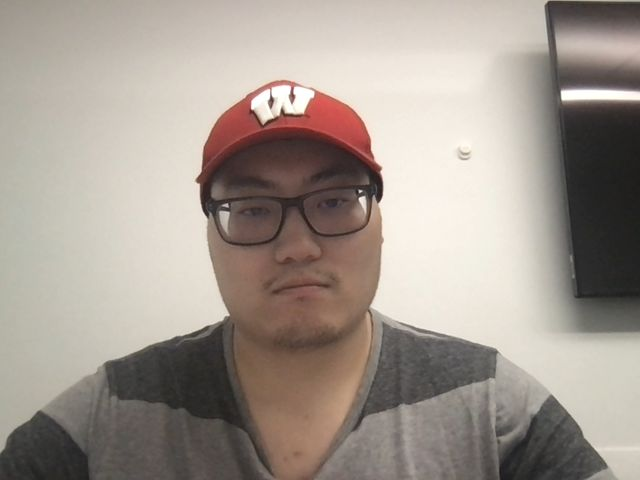

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from PIL import Image

# Path to the captured image
IMAGE_PATH = "/content/photo.jpg"

image_np = load_image_into_numpy_array(IMAGE_PATH)
# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]
detections = detect_fn(input_tensor)

Done


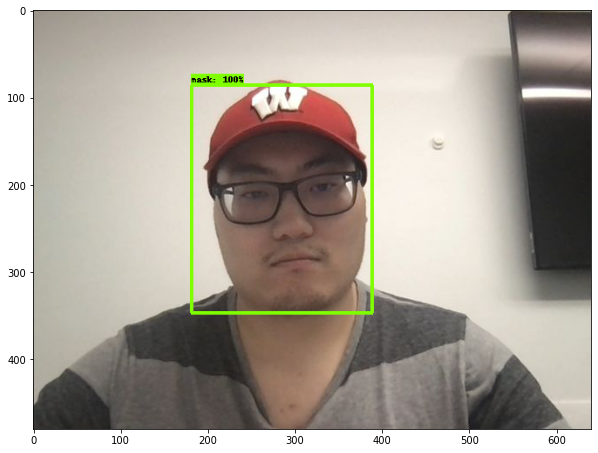

In [ ]:
# All outputs are batches of tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.50
      )

plt.figure(figsize = (10, 10))
plt.imshow(image_np_with_detections)
print('Done')
plt.show()

# Inference on a Webcam Stream

We can't do real time detection on a video stream. This colab captures video from a webcam stream and prints an image of the model's bounding boxes on the right hand side. Clicking on the photo or the video stream will end the stream.

The lag occurs even if I don't use a model to do object detection. For example if I remove all of the model detection code and simply display the images captured from the videostream there is still lag. I think to do real time detection on a webcam stream will require exporting my model to javascript and more javascripting than I currently know how to do. 

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import PIL
import io
import html
import time

## Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_np(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  imageBGR = cv2.imdecode(jpg_as_np, cv2.IMREAD_COLOR)
  # change the colors from BGR to RGB
  imageRGB = cv2.cvtColor(imageBGR , cv2.COLOR_BGR2RGB)
  
  return imageRGB

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  # bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGB')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      // I think zIndex means the thing will be overlayed or underlayed
      // imgElement.style.zIndex = 1;
      // I added the following parts - I just guessed at the pixels
      imgElement.style.left = '650px';
      imgElement.style.top = '5px';


      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# Trying My Model with the Video Stream

I'm going to use bbox as a placeholder for my image that I've written over

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    # OpenCV is automatically a numpy array
    image_np = js_to_np(js_reply["img"])

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    detections = detect_fn(input_tensor)    

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.70
          )

    # Images need to be converted to bytes in order to be displayed via js 
    image_np_with_detections_bytes = bbox_to_bytes(image_np_with_detections)
    # The previous code displayed bounding boxes saved as the variable bbox
    # For us bbox will be a placeholder for the image we draw boxes on
    bbox = image_np_with_detections_bytes

<IPython.core.display.Javascript object>

# References 

**Single image inference**

I used the following blogs and sites (in order that I found them helpful):

1.   https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model.html#download-the-test-images
2.   https://techzizou.com/training-an-ssd-model-for-a-custom-object-using-tensorflow-2-x/#tf2_step14
3.   [Roboflow Colab Notebook](https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD#scrollTo=wHfsJ5nWLWh9&uniqifier=1)
4.   [Link to the Roboflow blogpost](https://blog.roboflow.com/train-a-tensorflow2-object-detection-model/#export-trained-tensorflow-2-object-detector-weights)
5.   https://www.tensorflow.org/hub/tutorials/tf2_object_detection

**Webcam image inference**
1.   https://github.com/theAIGuysCode/colab-webcam

**Some alternative options for webcam video inference**

*   https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html
*   https://codelabs.developers.google.com/codelabs/tensorflowjs-object-detection#7

> The link suggests using the site Glitch to host a webapp. Here is a link to their web app on Glitch
* https://glitch.com/edit/#!/tensorflow-js-object-detection?path=index.html%3A38%3A41




